In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import warnings
from colorama import Fore, Style
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
import lightgbm
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
import catboost

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [2]:
def amex_metric(y_true, y_pred, return_components=False) -> float:
    def top_four_percent_captured(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(df) -> float:
        """Corresponds to 2 * AUC - 1"""
        df2 = pd.DataFrame({'target': df.target, 'prediction': df.target})
        df2.sort_values('prediction', ascending=False, inplace=True)
        return weighted_gini(df) / weighted_gini(df2)

    df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})
    df.sort_values('prediction', ascending=False, inplace=True)
    g = normalized_weighted_gini(df)
    d = top_four_percent_captured(df)

    if return_components: return g, d, 0.5 * (g + d)
    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

In [3]:
CFG = {
    'num_folds': 5,


    'catboost': {
        'depth': 6,
        'iterations': 3000,
    },

    'make_submit': True,
    'seed': 777
}

In [4]:
features_avg = ['B_1', 'B_11', 'B_16', 'B_17', 'B_18', 'B_2', 'B_20',
                'B_28', 'B_3', 'B_4', 'B_5', 'B_7', 'B_9', 'D_112',
                'D_121', 'D_141', 'D_39', 'D_41', 'D_42', 'D_43',
                'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 
                'D_50', 'D_51', 'D_53', 'D_54', 'D_56', 'D_58', 
                'D_59', 'D_60', 'D_91', 'P_2', 'P_3', 'R_1', 'R_2', 
                'R_27', 'R_3', 'R_7', 'S_11', 'S_26', 'S_3', 'S_5']
features_last = ['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_15', 'B_16',
                 'B_17', 'B_18', 'B_19', 'B_2', 'B_20', 'B_22', 'B_23',
                 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_3',
                 'B_32', 'B_33', 'B_36', 'B_38', 'B_39', 'B_4', 'B_40',
                 'B_41', 'B_42', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9',
                 'D_102', 'D_103', 'D_105', 'D_106', 'D_107', 'D_109',
                 'D_112', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120',
                 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 
                 'D_129', 'D_132', 'D_133', 'D_135', 'D_136', 'D_137', 
                 'D_140', 'D_141', 'D_143', 'D_145', 'D_39', 'D_41',
                 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48',
                 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55',
                 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63',
                 'D_64', 'D_66', 'D_70', 'D_72', 'D_73', 'D_74', 'D_75',
                 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_82', 'D_83',
                 'D_84', 'D_86', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96',
                 'P_2', 'P_3', 'R_1', 'R_10', 'R_11', 'R_12', 'R_13',
                 'R_14', 'R_15', 'R_17', 'R_18', 'R_19', 'R_2', 'R_20', 
                 'R_21', 'R_22', 'R_24', 'R_25', 'R_26', 'R_27', 'R_3',
                 'R_4', 'R_5', 'R_7', 'R_8', 'R_9', 'S_11', 'S_12',
                 'S_13', 'S_15', 'S_17', 'S_20', 'S_22', 'S_23', 
                 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6',
                 'S_7', 'S_8', 'S_9']

In [5]:
def get_data(path, train=False):
    data = pd.read_feather(path)
    cid = pd.Categorical(data.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1))
    if train: target = data.loc[last, 'target']
    df_avg = data[features_avg].groupby(cid).mean().rename(columns={f: f"{f}_avg" for f in features_avg})
    data = data.loc[last, features_last].rename(columns={f: f"{f}_last" for f in features_last}).set_index(np.asarray(cid[last]))
    data = pd.concat([data, df_avg], axis=1)

    cat_features = data.select_dtypes(['category']).columns.tolist()
    data[cat_features] = data[cat_features].astype('str')

    if train: return data, target
    else: return data, cat_features

train_data, target = get_data('data/train_data.ftr', train=True)
test_data, cat_features = get_data('data/test_data.ftr')

le_encoder = LabelEncoder()
for feature in cat_features:
    train_data[feature] = le_encoder.fit_transform(train_data[feature])
    test_data[feature] = le_encoder.transform(test_data[feature])

gc.collect()

0

In [6]:
train_data

,B_1_last,B_10_last,B_11_last,B_12_last,B_13_last,B_15_last,B_16_last,B_17_last,B_18_last,B_19_last,...,P_3_avg,R_1_avg,R_2_avg,R_27_avg,R_3_avg,R_7_avg,S_11_avg,S_26_avg,S_3_avg,S_5_avg
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.009384,0.326172,0.010262,0.112305,0.100098,0.014549,0.006409,NaN,1.007812,0.005276,...,0.680176,0.004509,0.005753,1.005859,0.004753,0.005852,0.469971,0.012558,0.113220,0.029114
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.034698,0.297119,0.014572,0.019043,0.017685,0.009537,0.002939,NaN,1.003906,0.008049,...,0.566895,0.006245,0.006252,1.005859,0.057678,0.005768,0.375488,0.004070,0.120605,0.016785
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.004284,0.296387,0.005093,0.007160,0.001749,0.006031,0.007835,NaN,1.003906,0.005951,...,0.618164,0.006622,0.006054,1.004883,0.005234,0.005898,0.285156,0.005924,NaN,0.005947
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.012566,0.411621,0.005489,0.074829,0.055908,0.002199,0.089172,1.007812,1.006836,0.007713,...,0.610840,0.005665,0.006607,1.004883,0.064758,0.004787,0.303223,0.019455,0.247803,0.056305
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.007679,0.125244,0.001000,0.013039,0.006050,0.005840,0.005096,NaN,0.531250,0.006706,...,0.527344,0.004181,0.003586,1.005859,0.020432,0.005974,0.307861,0.003868,0.173096,0.005051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.028519,0.436035,0.024429,0.284424,0.342285,0.004768,0.000352,NaN,1.001953,0.002272,...,0.696289,0.005459,0.006233,1.004883,0.165405,0.005924,0.244995,0.099609,0.125977,0.239258
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.292480,0.021011,0.233765,0.007530,0.007442,0.009941,1.005859,0.860840,0.098267,0.750488,...,0.606934,0.005543,0.004139,1.006836,0.020111,0.004795,0.295166,0.005222,0.273682,0.008224
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.020569,0.302734,0.010727,0.048889,0.036316,0.007996,0.173584,0.228394,1.002930,0.002565,...,0.633301,0.004753,0.005478,1.005859,0.081970,0.005432,0.484619,0.005127,0.084351,0.069275
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145b2c3d01967fcce461,0.015839,0.035461,0.002506,0.009682,0.007168,0.002916,0.509277,0.737305,0.465088,0.008972,...,0.504883,0.023468,0.004715,1.003906,0.120789,0.004910,0.316162,0.006371,0.357910,0.014671


In [7]:
features = [f for f in train_data.columns if f not in ('customer_ID', 'target')]
score_list = []
y_pred_list = []
kf = StratifiedKFold(n_splits=CFG['num_folds'], random_state=CFG['seed'], shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_data, target)):
    start_time = datetime.datetime.now()
    X_tr, X_va = train_data.iloc[idx_tr][features], train_data.iloc[idx_va][features]
    y_tr, y_va = target.iloc[idx_tr], target.iloc[idx_va]

    model = CatBoostClassifier(
        depth=CFG['catboost']['depth'],
        iterations=CFG['catboost']['iterations'],
        # learning_rate=0.05,
        custom_metric=['AUC'],
        random_seed=CFG['seed'],
        thread_count=6,
        early_stopping_rounds=300
    )
    
    model.fit(Pool(X_tr, y_tr, cat_features=cat_features),
              eval_set=Pool(X_va, y_va, cat_features=cat_features),
              verbose=100)

    y_va_pred = model.predict_proba(Pool(X_va, cat_features=cat_features))[:,1]
    score = amex_metric(y_va.values, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    y_pred_list.append(model.predict_proba(Pool(test_data[features], cat_features=cat_features))[:,1])
    gc.collect()

print(f"{Fore.RED}{Style.BRIGHT}OOF Score:   {np.mean(score_list):.5f}{Style.RESET_ALL}")

Learning rate set to 0.084503
0:	learn: 0.5950111	test: 0.5947036	best: 0.5947036 (0)	total: 232ms	remaining: 11m 34s
100:	learn: 0.2270314	test: 0.2266615	best: 0.2266615 (100)	total: 13.6s	remaining: 6m 31s
200:	learn: 0.2198646	test: 0.2218866	best: 0.2218866 (200)	total: 26.8s	remaining: 6m 13s
300:	learn: 0.2151875	test: 0.2201419	best: 0.2201419 (300)	total: 40.1s	remaining: 5m 59s
400:	learn: 0.2114237	test: 0.2193423	best: 0.2193423 (400)	total: 53.5s	remaining: 5m 46s
500:	learn: 0.2080773	test: 0.2188660	best: 0.2188660 (500)	total: 1m 6s	remaining: 5m 32s
600:	learn: 0.2049844	test: 0.2185463	best: 0.2185463 (600)	total: 1m 19s	remaining: 5m 18s
700:	learn: 0.2021387	test: 0.2182936	best: 0.2182936 (700)	total: 1m 32s	remaining: 5m 3s
800:	learn: 0.1993842	test: 0.2182763	best: 0.2182168 (784)	total: 1m 45s	remaining: 4m 50s
900:	learn: 0.1967711	test: 0.2182427	best: 0.2182168 (784)	total: 1m 58s	remaining: 4m 36s
1000:	learn: 0.1941493	test: 0.2180496	best: 0.2180496 (1000

KeyboardInterrupt: 

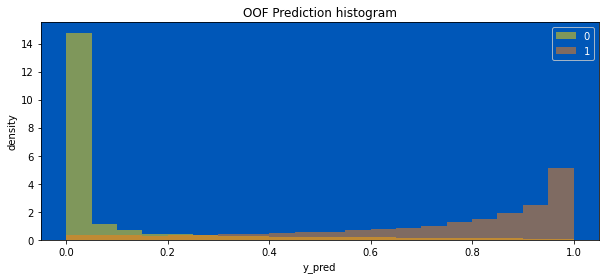

In [ ]:
plt.figure(figsize=(10, 4))
plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='0')
plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

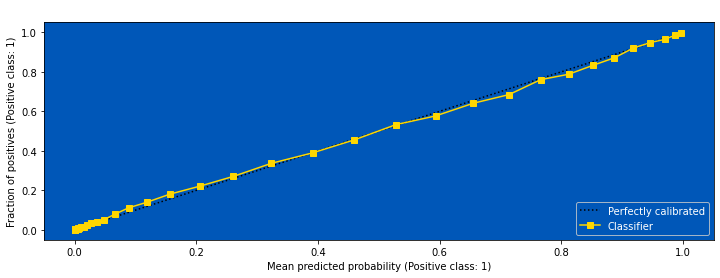

In [ ]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

In [ ]:
if CFG['make_submit']:
    sub = pd.DataFrame({'customer_ID': test_data.index,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission_v2.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.018035
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000684
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.020189
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.304872
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.887226
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.017495
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.735137
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.536987
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.311232
